# importamos datos


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from lazypredict.Supervised import LazyRegressor
import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.metrics import *
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib


data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv")
data.to_csv('/workspaces/machine-learning-joel/data/raw/AB_NYC_2019.csv',index=False)
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Obtenemos las dimenciones y la informacion del dataset


In [58]:
data.shape

(48895, 16)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

en esta caso podemos observar que tenemos un par de columnas en las que hay considerable cantidad de valores nulos como lo son last_review y reviews_per_month

In [60]:
data.nunique()

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

aqui revizamos que no existan columnas con valores unicos que no nos servirian para el proyecto como lo vemos no es el caso 

# Empezamos con la limpieza de datos 


Revizamos si existen duplicados 

In [61]:
data.duplicated().sum()

0

revisamos la proporcion de valores nulos que tenemos en cara columna 

In [62]:
data.isnull().mean()*100

id                                0.00
name                              0.03
host_id                           0.00
host_name                         0.04
neighbourhood_group               0.00
neighbourhood                     0.00
latitude                          0.00
longitude                         0.00
room_type                         0.00
price                             0.00
minimum_nights                    0.00
number_of_reviews                 0.00
last_review                      20.56
reviews_per_month                20.56
calculated_host_listings_count    0.00
availability_365                  0.00
dtype: float64

en este caso podemos ver que las columnas "last_review"y"reviews_per_month" con nulas en el 20 porciento de las veces y que las variables name y host_name lo son en un porcentaje muy pequeño tenemso que decidir que hacer con las columnas "last_review" y "reviews_per_month" si direcvtamente no tenerlas en cuenta es decir eliminar las columnas o generar datos para estas para no tener que quitar tantos datos 

primero que nada nos vamos quitar las columnas "name","id","host_name" ya que estas considero que no son relevantes en nuestro analisis 

In [63]:
data.drop(['id','name','host_name'], axis=1, inplace=True)

Pasaremso a revizar que porcentaje total representan las variables nulas que nos quedan 

In [64]:
data.isnull().any(axis=1).sum()/len(data)*100

20.55833929849678

podenmos observar que representan el 20.5% si recordamos antes teniamos 2 columnas que tenian este mismo porcentaje cada una de valores nulos lo que quiere decir que seguramente exista un patron en el que cuando una es nula en la otra columna tambien lo sea de todas maneras revisaremos si este patron existe aunque ya lo podemos asumir 

<Axes: >

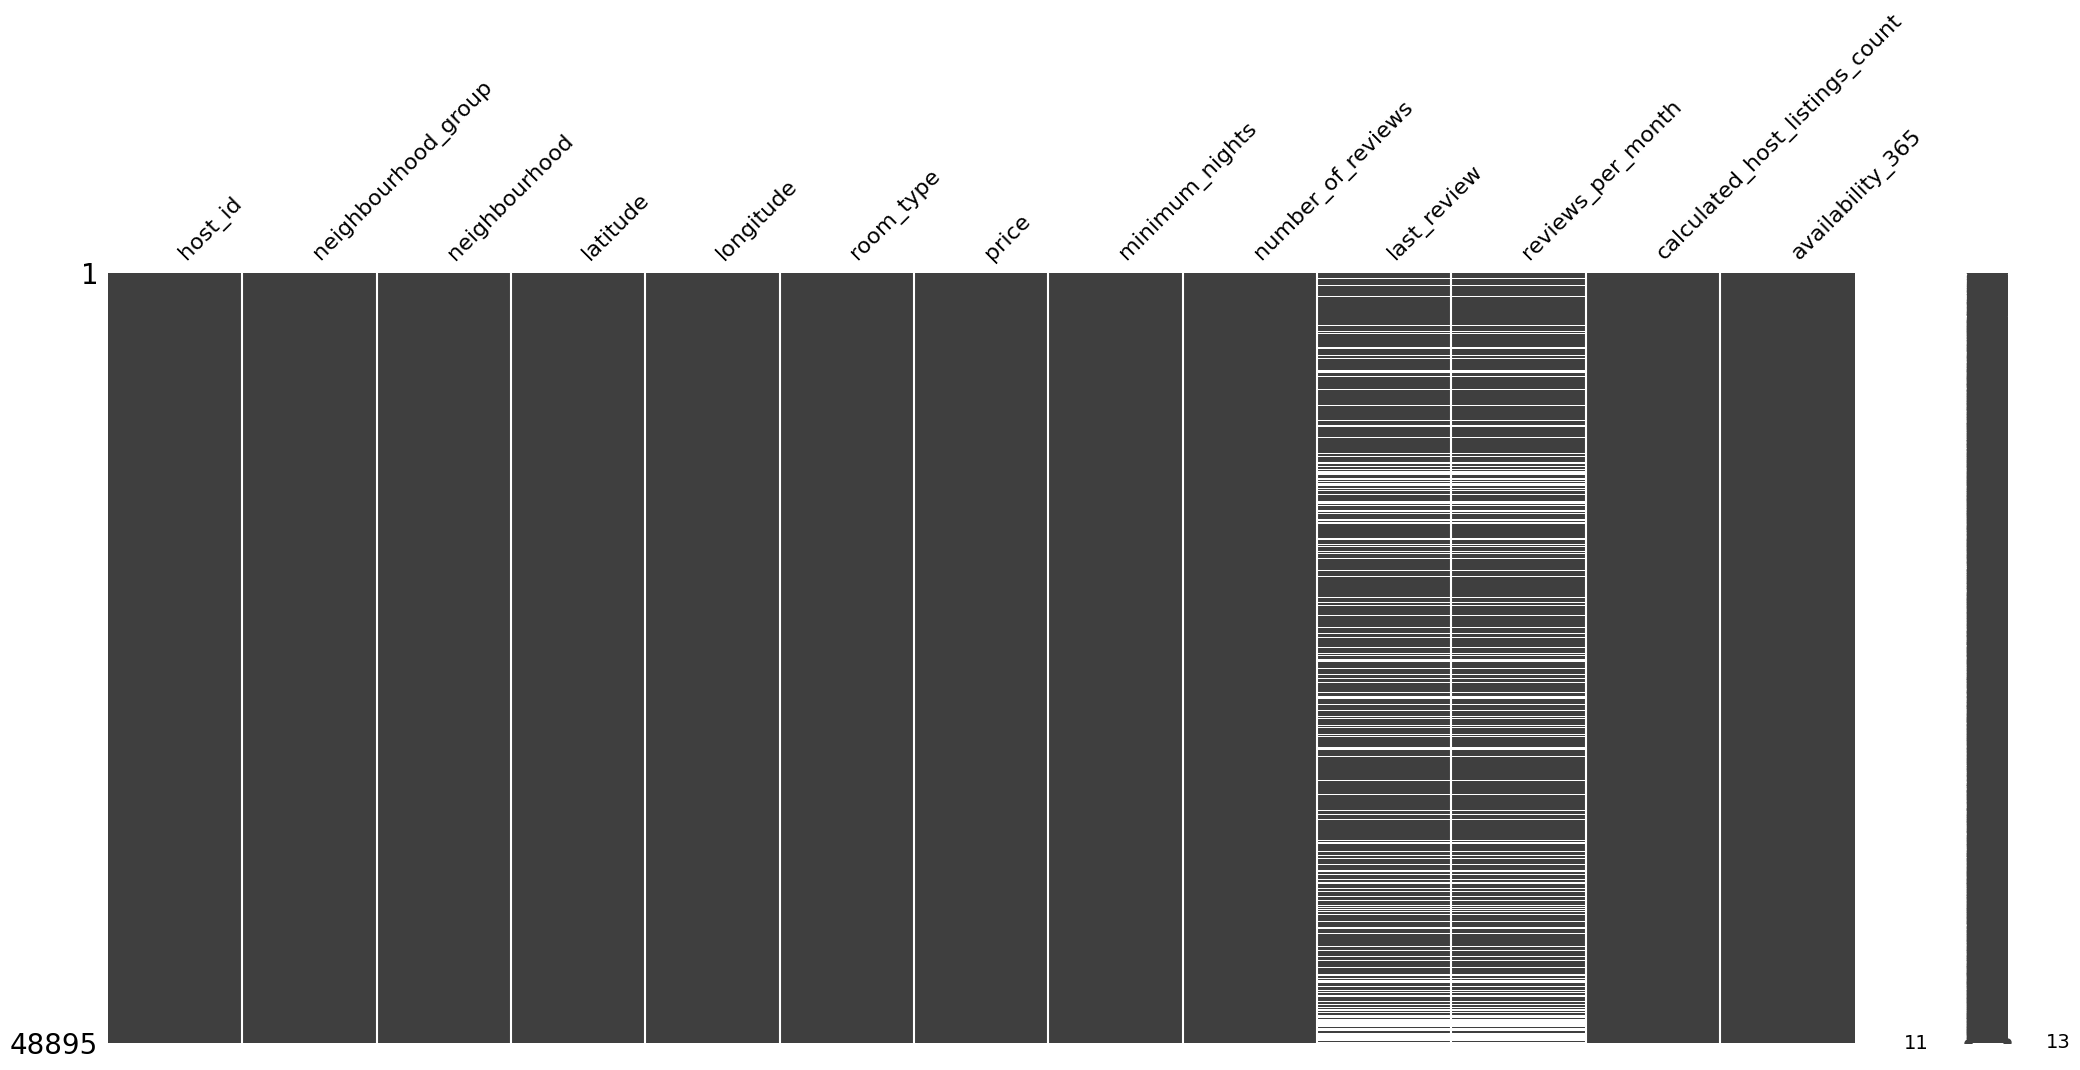

In [65]:
msno.matrix(data)

como podemos ver en la imagen existe un patron en el que si es nulo el valor en la columnaa de las_review en la columna de review_per_month tambien existe un valor nulo yo personalmente teniendo la columna de numbers_of_reviews que no tiene valores nulos me parecen irrelevantes los valores en estas 2 columnas para mi analisis asi que voy a proceder a eliminar las estas 2 ultimas 

In [66]:
data.drop(['last_review','reviews_per_month'], axis=1, inplace=True)

Revisamos nuevamente si existen valores nulos 

In [67]:
data.isnull().mean()*100

host_id                          0.00
neighbourhood_group              0.00
neighbourhood                    0.00
latitude                         0.00
longitude                        0.00
room_type                        0.00
price                            0.00
minimum_nights                   0.00
number_of_reviews                0.00
calculated_host_listings_count   0.00
availability_365                 0.00
dtype: float64

Ya no tenemos valores nulos  asi que procederemos con el analisis de Variables Categoricas 

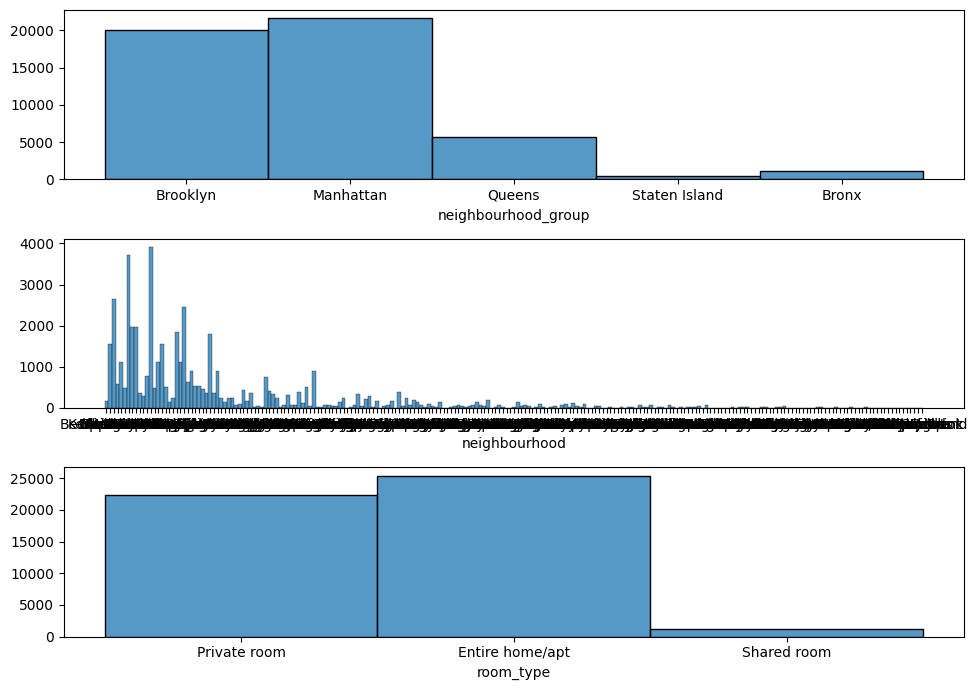

In [68]:
fig, axis = plt.subplots(3, figsize = (10, 7))

sns.histplot(ax = axis[0], data = data, x = 'neighbourhood_group').set(ylabel = None)
sns.histplot(ax = axis[1], data = data, x = 'neighbourhood').set(ylabel = None)
sns.histplot(ax = axis[2], data = data, x = 'room_type').set(ylabel = None)
plt.tight_layout()
plt.show()

neighbourhood_group: Podemos observar que en los barrios de Brooklyn y Manhattan se concentran la mayoria de arbnb esto debe ser producto a ser los barrios mas turisticos de la ciudad 

neighbourhood: en este caso tenemos muchas opciones hay que revisar si es relevante hacer el modelo utilizando unicamente la columna neighbourhood_group

room_type: podemos ver que no hay casi arbnb que sean cuartos compartidos seguramente sea la opcion menos demandada 

# Ahora pasamos a verificar la variable objetivo (precio):


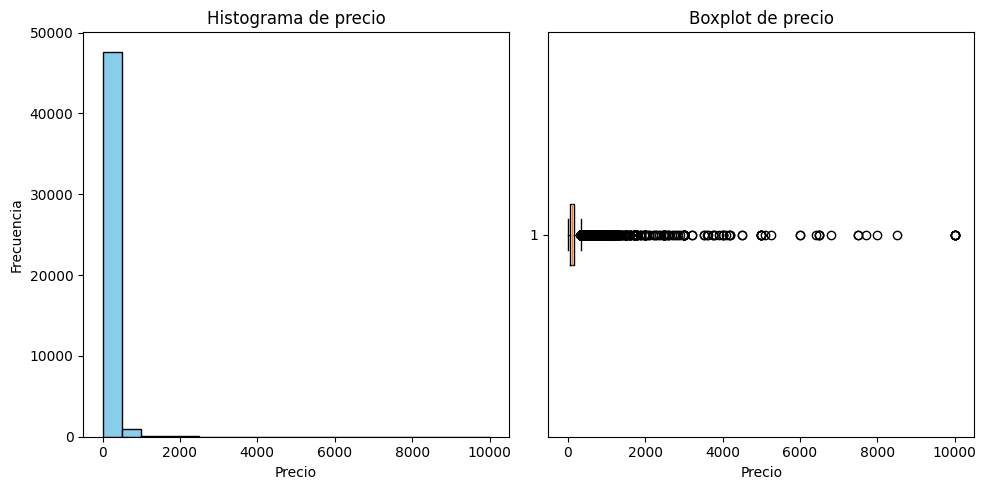

In [69]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(data['price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de precio')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(data['price'], vert=False)
ax[1].set_title('Boxplot de precio')
ax[1].set_xlabel('Precio')

plt.tight_layout()
plt.show()


podemos observar que en este caso no podamos hacer un modelo con esta variable y tengamos que aplicarle una funcion a la misma para que esta pueda ser manejable y lo haremos con la funcion logaritmica 

In [70]:
sum(data['price'] < 1 )

11

Podemos observar quye existen arbnbs con valores que son menores a 1 lo que me pareve muy extraño vamos a proceder a quitar estos valores 

In [71]:
data = data[data.price>1]

In [72]:
data['log_price'] = np.log(data.price)

data.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price
0,2787,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,6,365,5.00
1,2845,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2,355,5.42
2,4632,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,1,365,5.01
3,4869,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,1,194,4.49
4,7192,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,1,0,4.38


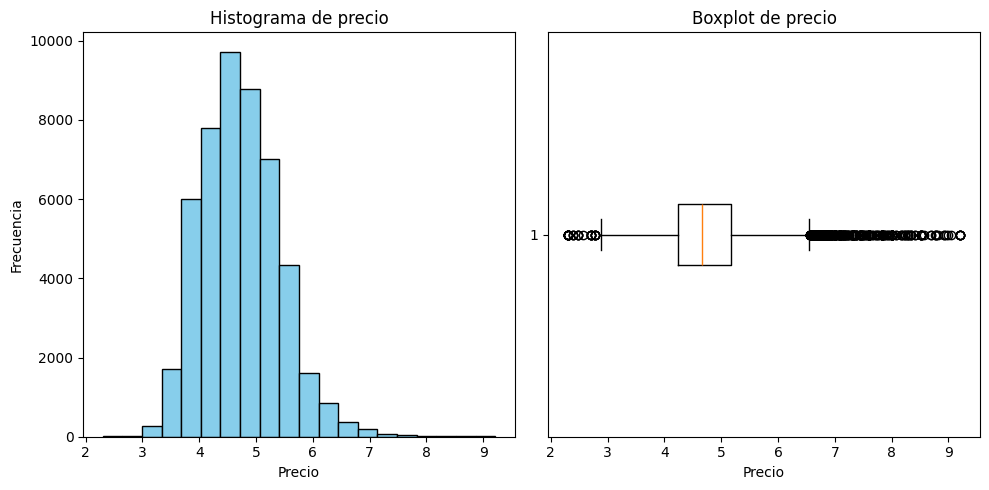

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(data['log_price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de precio')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(data['log_price'], vert=False)
ax[1].set_title('Boxplot de precio')
ax[1].set_xlabel('Precio')

plt.tight_layout()
plt.show()

podemos observar las graficas mas simetricas que es lo quue buscamos

In [74]:
X = data.drop(['price', 'log_price','neighbourhood_group','neighbourhood','room_type'], axis=1)
X = X.astype(int)
y = data['log_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
cooks_distance = model.get_influence().cooks_distance

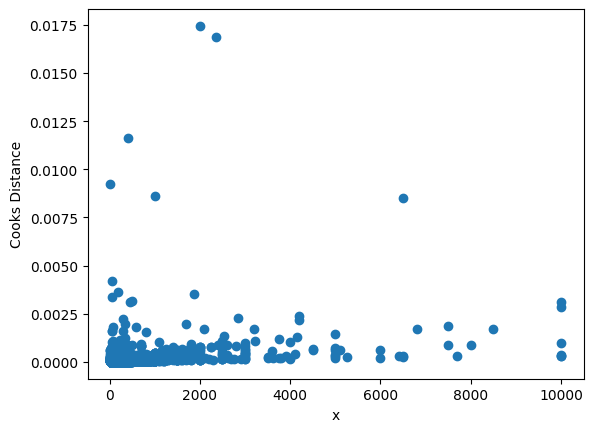

In [75]:
plt.scatter(data.price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [76]:
indices= np.where(cooks_distance[0]>0.0010)[0]
data.iloc[indices]


,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price
2163,273174,Manhattan,Tribeca,40.72,-74.00,Entire home/apt,575,1,447,3,207,6.35
2214,5709288,Manhattan,Midtown,40.76,-73.96,Entire home/apt,220,360,1,1,0,5.39
2854,6676776,Manhattan,Battery Park City,40.71,-74.02,Entire home/apt,400,1000,0,1,362,5.99
3398,4191006,Manhattan,West Village,40.74,-74.01,Private room,500,365,0,1,0,6.21
4372,160337,Manhattan,Washington Heights,40.84,-73.95,Entire home/apt,60,365,9,1,291,4.09
5767,17550546,Manhattan,Greenwich Village,40.73,-74.00,Entire home/apt,180,1250,2,1,365,5.19
6898,25404246,Manhattan,Nolita,40.72,-74.00,Entire home/apt,346,198,163,1,0,5.85
8014,10720264,Manhattan,Harlem,40.82,-73.96,Entire home/apt,75,500,0,1,362,4.32
9151,20582832,Queens,Astoria,40.77,-73.92,Private room,10000,100,2,1,0,9.21
11193,8996336,Brooklyn,Crown Heights,40.67,-73.95,Private room,50,500,10,1,365,3.91


procedemos a quitar las filas 

In [77]:
list(indices)
data.drop(indices,inplace=True)


In [78]:
data_int = data.drop(['neighbourhood_group','neighbourhood','room_type'], axis=1)

data_int.apply(lambda x: x.skew())



host_id                           1.21
latitude                          0.24
longitude                         1.29
price                            18.35
minimum_nights                   19.11
number_of_reviews                 3.68
calculated_host_listings_count    7.93
availability_365                  0.76
log_price                         0.59
dtype: float64

In [79]:
binary_cols = data_int[(data_int == 0)|(data_int == 1)].dropna(axis=1).columns
df_numerical = data_int.drop(binary_cols, axis=1)

In [80]:
def winsorize_column(column, lower, upper):
    q1 = column.quantile(lower)
    q3 = column.quantile(upper)
    iqr_value = q3-q1
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    column = column.clip(lower=lower_bound, upper=upper_bound)
    return column


for column in df_numerical.columns:
    df_numerical[column] = winsorize_column(df_numerical[column], 0.25, 0.75)

In [81]:
df_numerical.apply(lambda x: x.skew())

host_id                          1.18
latitude                         0.24
longitude                        0.53
price                            1.02
minimum_nights                   1.29
number_of_reviews                1.23
calculated_host_listings_count   1.15
availability_365                 0.76
log_price                        0.32
dtype: float64

In [82]:
df_new = pd.concat([df_numerical, data_int[binary_cols]], axis=1)

df_new

# libreria para neighbourhood hhttps://pypi.org/project/category-encoders/

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price
0,2787.00,40.65,-73.97,149,1,9.00,3.50,365,5.00
1,2845.00,40.75,-73.98,225,1,45.00,2.00,355,5.42
2,4632.00,40.81,-73.94,150,3,0.00,1.00,365,5.01
3,4869.00,40.69,-73.96,89,1,58.50,1.00,194,4.49
4,7192.00,40.80,-73.94,80,10,9.00,1.00,0,4.38
...,...,...,...,...,...,...,...,...,...
48890,8232441.00,40.68,-73.95,70,2,0.00,2.00,9,4.25
48891,6570630.00,40.70,-73.93,40,4,0.00,2.00,36,3.69
48892,23492952.00,40.81,-73.95,115,10,0.00,1.00,27,4.74
48893,30985759.00,40.76,-73.99,55,1,0.00,3.50,2,4.01


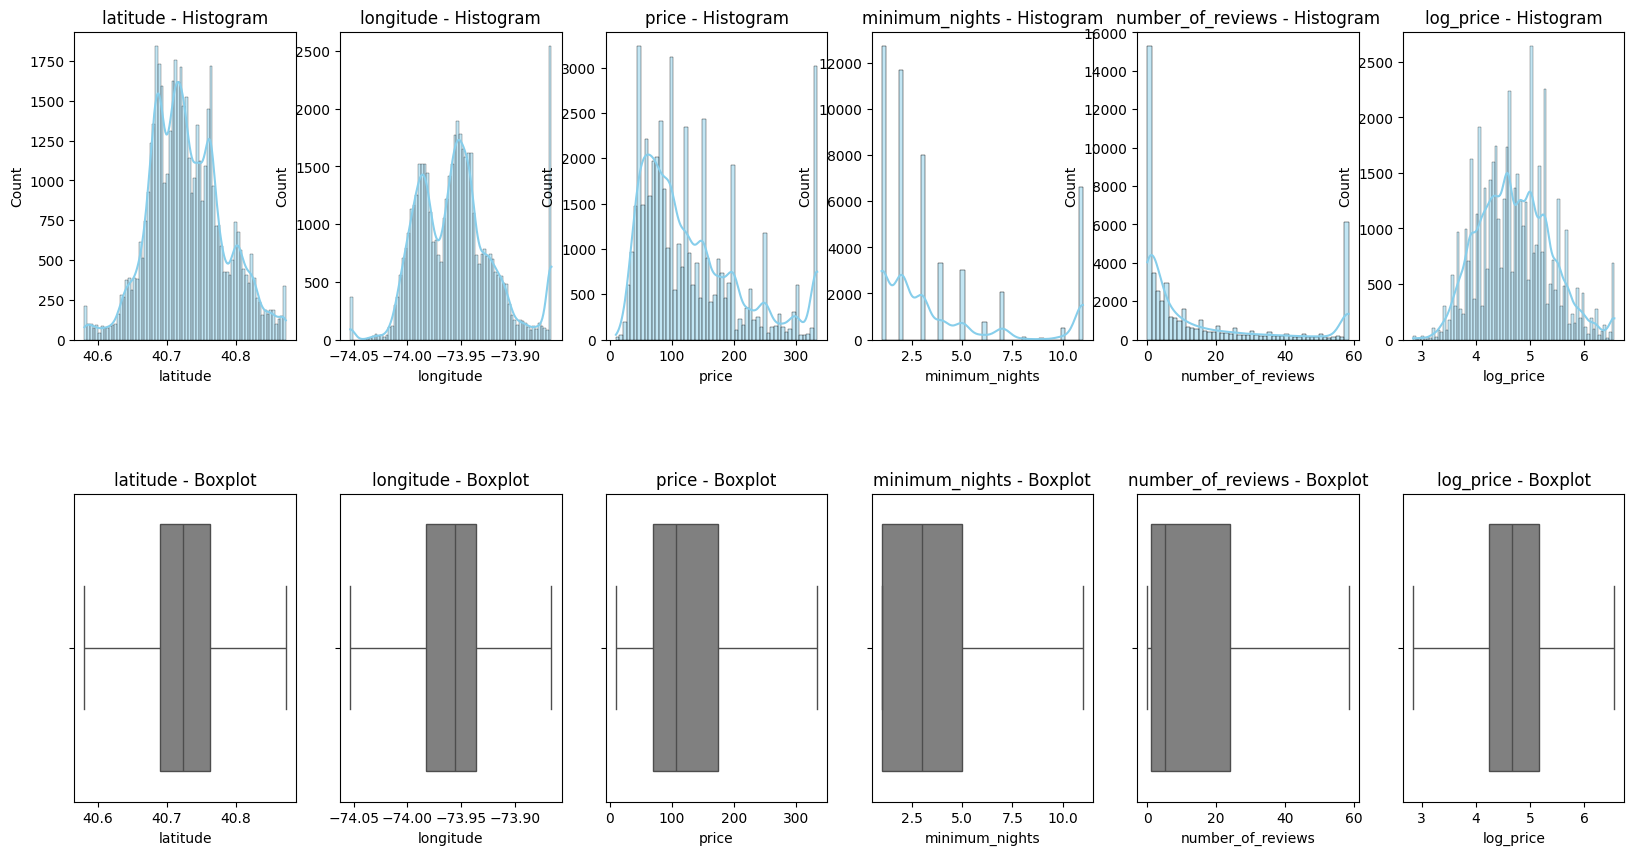

In [83]:
col_num = ["latitude","longitude","price","minimum_nights","number_of_reviews","log_price"]
fig, axes = plt.subplots(nrows=2, ncols=len(col_num), figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)

# Plotear histogramas y boxplots
for i, col in enumerate(col_num):
    # Histograma
    sns.histplot(ax=axes[0, i], data=df_new, x=col, color='skyblue', kde=True)
    axes[0, i].set_title(f"{col} - Histogram")

    # Boxplot
    sns.boxplot(x=col, data=df_new, ax=axes[1, i], color='gray')
    axes[1, i].set_title(f"{col} - Boxplot")
plt.show()

In [84]:
def confort_level(room_type):
    if room_type == 'Shared room': return 0
    elif room_type == 'Private room': return 1
    elif room_type == 'Entire home/apt': return 2
    else: return None

df_new['confort_level'] = data.room_type.apply(confort_level)
 

acontinuacion otra manera de hacerlo


df_new['confort_level']= pd.factorize(data["room_type"])[0]
df_new['confort_level']



In [85]:
df_encoded = pd.get_dummies(data['neighbourhood_group'], prefix='neighbourhood_group')
df_new = pd.concat([df_new, df_encoded], axis=1)
df_new

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,confort_level,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,2787.00,40.65,-73.97,149,1,9.00,3.50,365,5.00,1,False,True,False,False,False
1,2845.00,40.75,-73.98,225,1,45.00,2.00,355,5.42,2,False,False,True,False,False
2,4632.00,40.81,-73.94,150,3,0.00,1.00,365,5.01,1,False,False,True,False,False
3,4869.00,40.69,-73.96,89,1,58.50,1.00,194,4.49,2,False,True,False,False,False
4,7192.00,40.80,-73.94,80,10,9.00,1.00,0,4.38,2,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,8232441.00,40.68,-73.95,70,2,0.00,2.00,9,4.25,1,False,True,False,False,False
48891,6570630.00,40.70,-73.93,40,4,0.00,2.00,36,3.69,1,False,True,False,False,False
48892,23492952.00,40.81,-73.95,115,10,0.00,1.00,27,4.74,2,False,False,True,False,False
48893,30985759.00,40.76,-73.99,55,1,0.00,3.50,2,4.01,0,False,False,True,False,False


In [86]:
label_encoder = LabelEncoder()
df_new['neighbourhood_encoded'] = label_encoder.fit_transform(data['neighbourhood'])
df_new

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,confort_level,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_encoded
0,2787.00,40.65,-73.97,149,1,9.00,3.50,365,5.00,1,False,True,False,False,False,108
1,2845.00,40.75,-73.98,225,1,45.00,2.00,355,5.42,2,False,False,True,False,False,127
2,4632.00,40.81,-73.94,150,3,0.00,1.00,365,5.01,1,False,False,True,False,False,94
3,4869.00,40.69,-73.96,89,1,58.50,1.00,194,4.49,2,False,True,False,False,False,41
4,7192.00,40.80,-73.94,80,10,9.00,1.00,0,4.38,2,False,False,True,False,False,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,8232441.00,40.68,-73.95,70,2,0.00,2.00,9,4.25,1,False,True,False,False,False,13
48891,6570630.00,40.70,-73.93,40,4,0.00,2.00,36,3.69,1,False,True,False,False,False,28
48892,23492952.00,40.81,-73.95,115,10,0.00,1.00,27,4.74,2,False,False,True,False,False,94
48893,30985759.00,40.76,-73.99,55,1,0.00,3.50,2,4.01,0,False,False,True,False,False,95


In [87]:
corr = df_new.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,confort_level,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_encoded
host_id,1.000,0.020,0.116,0.013,-0.064,-0.127,0.183,0.204,-0.019,-0.091,0.073,-0.116,0.002,0.132,0.035,-0.028
latitude,0.020,1.000,0.110,0.075,0.031,-0.026,-0.001,-0.011,0.083,-0.006,0.324,-0.676,0.595,0.017,-0.184,0.235
longitude,0.116,0.110,1.000,-0.365,-0.121,0.081,0.078,0.073,-0.388,-0.213,0.259,0.073,-0.491,0.593,-0.236,-0.126
price,0.013,0.075,-0.365,1.000,0.052,-0.066,-0.057,0.112,0.962,0.575,-0.091,-0.194,0.338,-0.173,-0.041,0.134
minimum_nights,-0.064,0.031,-0.121,0.052,1.000,-0.210,0.183,0.156,0.041,0.155,-0.050,-0.038,0.106,-0.076,-0.024,0.053
number_of_reviews,-0.127,-0.026,0.081,-0.066,-0.210,1.000,0.052,0.191,-0.047,0.005,0.022,0.025,-0.066,0.046,0.027,-0.050
calculated_host_listings_count,0.183,-0.001,0.078,-0.057,0.183,0.052,1.000,0.414,-0.091,-0.181,0.025,-0.064,0.002,0.076,0.026,-0.039
availability_365,0.204,-0.011,0.073,0.112,0.156,0.191,0.414,1.000,0.097,-0.023,0.061,-0.080,-0.005,0.087,0.058,-0.035
log_price,-0.019,0.083,-0.388,0.962,0.041,-0.047,-0.091,0.097,1.000,0.630,-0.107,-0.195,0.355,-0.189,-0.047,0.142
confort_level,-0.091,-0.006,-0.213,0.575,0.155,0.005,-0.181,-0.023,0.630,1.000,-0.056,-0.062,0.149,-0.107,-0.008,0.072


Podemos si vemos la grafica podemos observar los valores mas destacados tenemos la relacion entre el precio y nivel de confort es bastante alta a continuacion mostraremso las variables que tienen una correlacion mas baja con respectoa  nuestra variable y luego las que mas tienen

In [88]:
corr[corr.log_price.abs()<0.1].index

Index(['host_id', 'latitude', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_Staten Island'],
      dtype='object')

In [89]:
corr[corr.log_price.abs()>0.4].index

Index(['price', 'log_price', 'confort_level'], dtype='object')

pues si vemos mas en detalle tenemos 'host_id', 'latitude', 'minimum_nights', 'number_of_reviews',
'calculated_host_listings_count', 'availability_365',
'neighbourhood_group_Staten Island' que no tienen practica mente correlacion con nuestro precio mientras que el 'confort_level' es la que mas tiene con diferencia a parte de obviamente el precio que seguramente tendremos que quitar del modelo 

In [90]:
corr.log_price

host_id                             -0.02
latitude                             0.08
longitude                           -0.39
price                                0.96
minimum_nights                       0.04
number_of_reviews                   -0.05
calculated_host_listings_count      -0.09
availability_365                     0.10
log_price                            1.00
confort_level                        0.63
neighbourhood_group_Bronx           -0.11
neighbourhood_group_Brooklyn        -0.20
neighbourhood_group_Manhattan        0.36
neighbourhood_group_Queens          -0.19
neighbourhood_group_Staten Island   -0.05
neighbourhood_encoded                0.14
Name: log_price, dtype: float64

In [91]:
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=df_new.columns)
vif

host_id                                2.01
latitude                              35.99
longitude                             37.33
price                               1109.38
minimum_nights                         2.74
number_of_reviews                      1.99
calculated_host_listings_count         2.90
availability_365                       3.50
log_price                           1339.45
confort_level                         15.66
neighbourhood_group_Bronx               inf
neighbourhood_group_Brooklyn            inf
neighbourhood_group_Manhattan           inf
neighbourhood_group_Queens              inf
neighbourhood_group_Staten Island       inf
neighbourhood_encoded                  1.73
dtype: float64

Revisamos la varianza inflacionaria de cada una de las variables y procedemos a quitar las variables que nos den como respouesta como infinita y obviamente el precio 

In [92]:
df_new.drop(['neighbourhood_group_Bronx','neighbourhood_group_Brooklyn','neighbourhood_group_Manhattan','neighbourhood_group_Queens','neighbourhood_group_Staten Island','price'], axis=1, inplace=True)

In [93]:
corr = df_new.corr()
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=df_new.columns)
vif

host_id                           1.62
latitude                          1.54
longitude                         2.77
minimum_nights                    2.30
number_of_reviews                 1.90
calculated_host_listings_count    2.64
availability_365                  3.27
log_price                        10.23
confort_level                     7.81
neighbourhood_encoded             1.43
dtype: float64

Empezamos a crear nuestro modelo 

In [94]:
X = df_new.drop(['log_price'], axis=1)
y = df_new['log_price']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
# Vamos a usar un método embebido que nos informe de la importancia de las características
# Crea un modelo XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror')

model.fit(X_train, y_train)

feature_importances = model.feature_importances_

feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

for feature, importance in sorted_feature_importance.items():
    print(f'Feature: {feature}, Importance: {importance*100}')

Feature: confort_level, Importance: 84.99225974082947
Feature: longitude, Importance: 3.851926699280739
Feature: latitude, Importance: 2.4565821513533592
Feature: minimum_nights, Importance: 2.1142197772860527
Feature: availability_365, Importance: 1.862112432718277
Feature: calculated_host_listings_count, Importance: 1.4816580340266228
Feature: number_of_reviews, Importance: 1.4000960625708103
Feature: neighbourhood_encoded, Importance: 0.9881376288831234
Feature: host_id, Importance: 0.8530107326805592


In [97]:
def get_vars_to_delete(d_imp, corr, imp_cut=0.005, corr_cut=0.1):
  ls_vals_low_corr = corr[corr.log_price.abs()<=corr_cut].index
  return [var for var in ls_vals_low_corr if d_imp[var]<=imp_cut]

In [98]:
vals_to_drop = get_vars_to_delete(sorted_feature_importance, corr, imp_cut=0.015, corr_cut=0.15)
vals_to_drop

['host_id',
 'number_of_reviews',
 'calculated_host_listings_count',
 'neighbourhood_encoded']

In [99]:
df_new.drop(vals_to_drop, axis=1, inplace=True)

In [100]:
df_new

,latitude,longitude,minimum_nights,availability_365,log_price,confort_level
0,40.65,-73.97,1,365,5.00,1
1,40.75,-73.98,1,355,5.42,2
2,40.81,-73.94,3,365,5.01,1
3,40.69,-73.96,1,194,4.49,2
4,40.80,-73.94,10,0,4.38,2
...,...,...,...,...,...,...
48890,40.68,-73.95,2,9,4.25,1
48891,40.70,-73.93,4,36,3.69,1
48892,40.81,-73.95,10,27,4.74,2
48893,40.76,-73.99,1,2,4.01,0


In [101]:
X = df_new.drop(['log_price'], axis=1)
y = df_new['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
binary_cols = X_train[(X_train==0)|(X_train==1)].dropna(axis=1).columns
X_train_num = X_train.drop(binary_cols, axis=1)
X_test_num = X_test.drop(binary_cols, axis=1)

In [103]:
scaler = MinMaxScaler().fit(X_train_num)

In [104]:
X_train_num_sc = scaler.transform(X_train_num)
X_test_num_sc = scaler.transform(X_test_num)

In [105]:
X_train_sc = pd.concat([pd.DataFrame(X_train_num_sc, columns = X_train_num.columns), X_train[binary_cols].reset_index(drop=True)], axis=1)
X_test_sc = pd.concat([pd.DataFrame(X_test_num_sc, columns = X_test_num.columns), X_test[binary_cols].reset_index(drop=True)], axis=1)

In [106]:
X_train_sc.head()

,latitude,longitude,minimum_nights,availability_365,confort_level
0,0.32,0.37,0.10,0.67,1.00
1,0.82,0.52,0.00,1.00,0.00
2,0.38,0.57,0.00,0.08,0.50
3,0.28,0.56,0.40,0.00,1.00
4,0.63,0.37,0.20,0.02,0.50


In [107]:
reg = LazyRegressor()
models, predictions = reg.fit(X_train_sc, X_test_sc, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [03:24<00:00,  4.86s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 39072, number of used features: 5
[LightGBM] [Info] Start training from score 4.721464


In [108]:
print(models)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LGBMRegressor                                0.62       0.62  0.41        0.23
HistGradientBoostingRegressor                0.62       0.62  0.41        0.49
XGBRegressor                                 0.62       0.62  0.41        0.30
RandomForestRegressor                        0.61       0.61  0.42       12.93
GradientBoostingRegressor                    0.60       0.60  0.42        3.96
NuSVR                                        0.60       0.60  0.43       70.59
MLPRegressor                                 0.59       0.59  0.43        7.90
SVR                                          0.59       0.59  0.43       54.58
ExtraTreesRegressor                          0.59       0.59  0.43        5.45
BaggingRegressor                             0.58       0.58  0.44        1.38
KNeighborsRegressor                          0.57   

In [109]:
model = lgb.LGBMRegressor()

param_dict = {'boosting_type': ['gbdt','dart','rf'],
              'num_leaves': np.arange(20, 250, 30),
              'max_depth':np.arange(20, 250, 30),
              'learning_rate':np.logspace(-3,0,5)}

random_search = RandomizedSearchCV(model, param_distributions=param_dict, n_iter=50, cv=5, random_state=42, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1,return_train_score=True)
random_search.fit(X_train_sc, y_train)
# Mostramos los mejores hiperparámetros encontrado

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 5
[LightGBM] [Info] Start training 

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 5
[LightGBM] [Info] Start training 

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 312

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 5
[LightGBM] [Info] Start training 

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 5
[LightGBM] [Info] Start training 

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 5
[LightGBM] [Info] Start training 

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 312

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 5
[LightGBM] [Info] Start training 

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 5
[LightGBM] [Info] Start training 

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 5
[LightGBM] [Info] Start training 

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 5
[LightGBM] [Info] Start training 

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 5
[LightGBM] [Info] Start training 

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 39072, number of used features: 5
[LightGBM] [Info] Start training from score 4.721464


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart', 'rf'],
                                        'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
                                        'max_depth': array([ 20,  50,  80, 110, 140, 170, 200, 230]),
                                        'num_leaves': array([ 20,  50,  80, 110, 140, 170, 200, 230])},
                   random_state=42, return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=1)

In [110]:
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)
print("Mejor puntuación (RMSE) en el conjunto de prueba:")
print(-1*random_search.best_score_)

Mejores hiperparámetros encontrados:
{'num_leaves': 80, 'max_depth': 110, 'learning_rate': 0.1778279410038923, 'boosting_type': 'gbdt'}
Mejor puntuación (RMSE) en el conjunto de prueba:
0.4235075440978326


In [111]:
model = lgb.LGBMRegressor()
param_dict = {'boosting_type': ['gbdt'],
              'num_leaves': np.arange(65, 120, 10),
              'max_depth':np.arange(90, 130, 10),
              'learning_rate':[0.15,0.17,0.19,0.21]}

opt = BayesSearchCV(
    model,
    param_dict,
    n_iter=50,  
    cv=5,       
    n_jobs=-1,
    random_state=42,
    scoring='neg_root_mean_squared_error',  
    verbose=2
)
opt.fit(X_train_sc, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.719840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 31257, number of used features: 5
[LightGBM] [Info] Start training from score 4.722963
[CV] END boosting_type=gbdt, learning_rate=0.19, max_depth=120, num_leaves=75; total time=   0.4s
[CV] END boosting_type=gbdt, learning_rate=0.19, max_depth=120, num_leaves=75; total time=   0.3s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

BayesSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1, random_state=42,
              scoring='neg_root_mean_squared_error',
              search_spaces={'boosting_type': ['gbdt'],
                             'learning_rate': [0.15, 0.17, 0.19, 0.21],
                             'max_depth': array([ 90, 100, 110, 120]),
                             'num_leaves': array([ 65,  75,  85,  95, 105, 115])},
              verbose=2)

In [112]:
# Imprime los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(opt.best_params_)

# Mostramos el rendimiento del mejor modelo
print("Mejor puntuación (RMSE) en el conjunto de prueba:")
print(-1*opt.best_score_)

Mejores hiperparámetros encontrados:
OrderedDict([('boosting_type', 'gbdt'), ('learning_rate', 0.15), ('max_depth', 120), ('num_leaves', 65)])
Mejor puntuación (RMSE) en el conjunto de prueba:
0.4221447564074693


In [113]:
modelo = opt.best_estimator_

In [114]:
y_pred_train = np.exp(modelo.predict(X_train_sc))
y_pred_test = np.exp(modelo.predict(X_test_sc))

In [115]:
y_train_co2 = np.exp(y_train)
y_test_co2 = np.exp(y_test)

In [117]:
min(y_train_co2)

17.08305951117629

In [119]:
print(mean_absolute_error(y_train_co2,y_pred_train))
print(mean_absolute_error(y_test_co2,y_pred_test))

44.330596168443954
46.244907583748784


In [120]:
print(r2_score(y_train_co2,y_pred_train))
print(r2_score(y_test_co2,y_pred_test))

0.4942369572078571
0.4465559990510968


In [121]:
print(mean_absolute_percentage_error(y_train_co2,y_pred_train)*100)
print(mean_absolute_percentage_error(y_test_co2,y_pred_test)*100)

28.785033209128315
31.714115760879828


In [122]:
model_bagging = BaggingRegressor(estimator=opt.best_estimator_, n_estimators=5, random_state=42).fit(X_train_sc, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 39072, number of used features: 5
[LightGBM] [Info] Start training from score 4.721870
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 39072, number of used features: 5
[LightGBM] [Info] Start training from score 4.715718
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

In [123]:
y_pred_train = np.exp(model_bagging.predict(X_train_sc))
y_pred_test = np.exp(model_bagging.predict(X_test_sc))

In [124]:
print(mean_absolute_error(y_train_co2,y_pred_train))
print(mean_absolute_error(y_test_co2,y_pred_test))

44.56179234323905
46.2630130150464


In [125]:
print(r2_score(y_train_co2,y_pred_train))
print(r2_score(y_test_co2,y_pred_test))

0.486862541277712
0.4450627518088731


In [126]:
print(mean_absolute_percentage_error(y_train_co2,y_pred_train)*100)
print(mean_absolute_percentage_error(y_test_co2,y_pred_test)*100)

28.858069616659748
31.632464054040216


In [129]:
def custom_transform(X):
    binary_cols = X[(X==0)|(X==1)].dropna(axis=1).columns
    X_num = X.drop(binary_cols, axis=1)
    X_num_sc = scaler.transform(X_num)
    X_sc = pd.concat([pd.DataFrame(X_num_sc), X[binary_cols].reset_index(drop=True)], axis=1, ignore_index=True)
    return X_sc

steps = [
    ('custom_transform', FunctionTransformer(func=custom_transform)),  # Paso con función personalizada
    ('modelo', model_bagging)  # Paso del modelo de regresión
]


pipeline = Pipeline(steps)

In [130]:
joblib.dump(pipeline, 'model_pipeline.pkl')

['model_pipeline.pkl']

In [131]:
loaded_pipeline = joblib.load('model_pipeline.pkl')

In [139]:
cols = [X_train_sc.columns]
new_house_data =pd.DataFrame([[40.75,-73.98,8,200,3]],columns=cols)   
print(round(np.exp(loaded_pipeline.predict(new_house_data))[0],2))

187.52
